In [1]:
import pandas as pd
import numpy as np
import spacy
from textblob import TextBlob

from statistics import mean, stdev
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from sklearn.preprocessing import binarize

In [2]:
data = pd.read_csv("project_18_dataset_combined.csv")
data = data[['label', 'text']]

#set display option
pd.set_option('display.max_colwidth', None)

#make target labels boolean
data['label']=data['label'].apply(lambda x: 1 if x == 14 else 0)

In [3]:
print(data.shape)
print(data.label.value_counts())
data.head()

(19821, 2)
0    18585
1     1236
Name: label, dtype: int64


,label,text
0,0,"Serious Youth Violence crimes, lone wolves basically."
1,0,Yesterday?
2,0,"I would argue with you, but it seems pointless. If I understand you, your argument is this: the UK can do whatever it wants the UK is never wrong"
3,0,"the whole thing is pretty dumb desu, school kids could be in a class of 12 or whatever all mingling and thats fine, but if they leave school and they all go to the park then thats not not allowed"
4,0,"I fucking hope you re right, lad."


In [4]:
#Balancing data
count_label_0, count_label_1 = data.label.value_counts()

data_label_1 = data[data['label'] == 1]
data_label_0 = data[data['label'] == 0]

data_label_0_b = data_label_0.sample(count_label_1, random_state=88)
data_b = pd.concat([data_label_0_b, data_label_1])
print(data_b.shape)
print(data_b.label.value_counts())
data_b.head()

(2472, 2)
0    1236
1    1236
Name: label, dtype: int64


,label,text
17921,0,pointing out the ruse is lower IQ than the people who just sit back and enjoy the show
17572,0,I am in bed dingus I am going to sleep Do not summon me again
15394,0,boy he just has the worst opinions about everything. But is he also the anti-awoo beaner?
19111,0,DAY OF THE RAKE!
189,0,Is it Constantine filming from the hell dimension?


In [5]:
#lemmatizing
nlp = spacy.load('en_core_web_sm')
data_b['text_lemmatized'] = data_b['text'].apply(lambda x: " ".join([words.lemma_ for words in nlp(x)]))

In [65]:
#train/test splitting again
X_train, X_test, y_train, y_test = train_test_split(data_b.text_lemmatized, data_b.label, test_size=0.25, random_state=14, stratify=data_b.label)

#remember to set parameters
pipeline = Pipeline([ ('vectorizer', TfidfVectorizer(lowercase=True, max_df=0.3, min_df=2, ngram_range=(1, 5), smooth_idf=True, sublinear_tf=True, use_idf=False)), ('classifier', MultinomialNB(alpha=0.1, fit_prior=False)) ])

model = pipeline.fit(X_train, y_train)

y_pred_class = model.predict(X_test)

In [66]:
#y_pred_class_new = binarize([y_pred_prob], 0.9)[0]

y_pred_class_new = (model.predict_proba(X_test)[:,1] >= 0.9).astype(bool)

In [67]:
print(confusion_matrix(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class_new))

[[229  80]
 [ 53 256]]
[[308   1]
 [246  63]]


In [68]:
print('default threshold accuracy:', accuracy_score(y_test, y_pred_class))
print('new threshold accuracy:', accuracy_score(y_test, y_pred_class_new))
print('-----')
print('default threshold precision:', precision_score(y_test, y_pred_class))
print('new threshold precision:', precision_score(y_test, y_pred_class_new))
print('-----')
print('default threshold recall:', recall_score(y_test, y_pred_class))
print('new threshold recall:', recall_score(y_test, y_pred_class_new))

default threshold accuracy: 0.7847896440129449
new threshold accuracy: 0.6003236245954693
-----
default threshold precision: 0.7619047619047619
new threshold precision: 0.984375
-----
default threshold recall: 0.8284789644012945
new threshold recall: 0.20388349514563106


In [10]:
threshold_range = (np.linspace(0.01,0.99,99))
y_pred_class_precision_scores = []
y_pred_class_recall_scores = []

for th in threshold_range:
    #insert model also?
    
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_class_new = (model.predict_proba(X_test)[:,1] >= th).astype(bool)
    
    y_pred_class_precision_scores.append(precision_score(y_test, y_pred_class_new))
    y_pred_class_recall_scores.append(recall_score(y_test, y_pred_class_new))

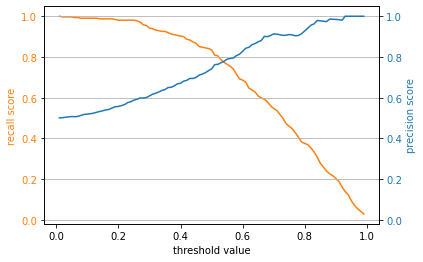

In [28]:
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('threshold value')
ax1.set_ylabel('recall score', color=color)
ax1.plot(threshold_range, y_pred_class_recall_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('precision score', color=color)
ax2.set_ylim(ax1.get_ylim())
ax2.plot(threshold_range, y_pred_class_precision_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)